In [1]:
import os
import sys
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_valid, x_train = x_train_full[:5000] / 255.0, x_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
x_test = x_test / 255.0
(x_train.shape, x_valid.shape, x_test.shape)

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

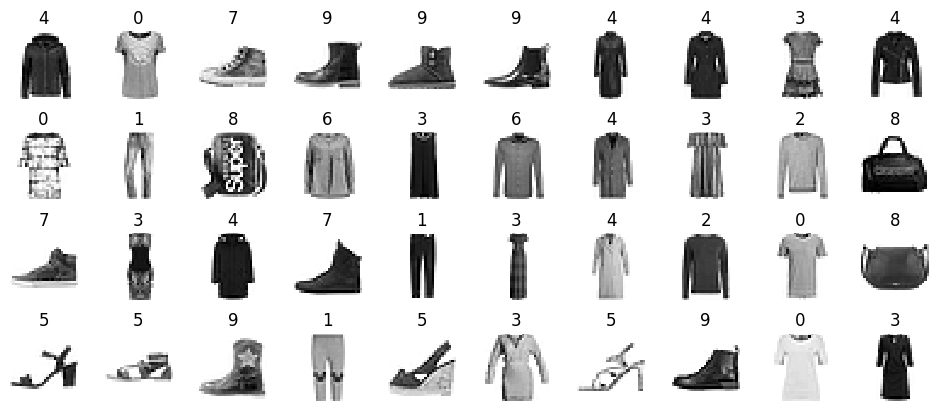

In [3]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [4]:
K = keras.backend


class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        current_rate = K.get_value(self.model.optimizer.learning_rate)
        self.rates.append(current_rate)
        self.losses.append(logs.get('loss'))
        self.model.optimizer.learning_rate.assign(current_rate * self.factor)

In [5]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(1.005)
model.fit(x_train, y_train, epochs=1, callbacks=[expon_lr],
          validation_data=(x_valid, y_valid))


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5029 - loss: nan - val_accuracy: 0.0914 - val_loss: nan


Text(0, 0.5, 'loss')

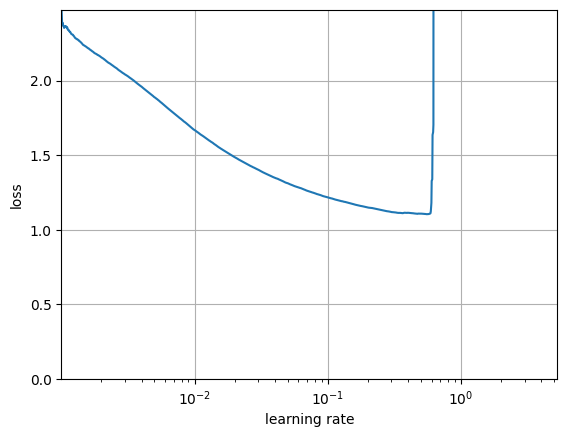

In [7]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale("log")
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid(True)
plt.xlabel("learning rate")
plt.ylabel("loss")

In [8]:
min_loss = min(expon_lr.losses)
min_index = expon_lr.losses.index(min_loss)
best_learning_rate = float(expon_lr.rates[min_index] / 12)
print(f"Best learning rate: {best_learning_rate}")

Best learning rate: 0.046030979603528976


In [9]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=best_learning_rate),
              metrics=["accuracy"])

In [10]:
from src.model_utils import Modelpath
from src.log_utils import logdir

modelpath = Modelpath("mnist_fashion3", format="keras")
Cheackpoint_cb = keras.callbacks.ModelCheckpoint(modelpath, save_best_only=True)
EarlyStopping_cb = keras.callbacks.EarlyStopping(patience=20)
tensorboard_cb = keras.callbacks.TensorBoard(logdir(name_logdir="mnist_fashion"))

In [11]:
model.fit(x_train, y_train, epochs=100,
          validation_data=(x_valid, y_valid),
          callbacks=[Cheackpoint_cb, EarlyStopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8006 - loss: 0.5649 - val_accuracy: 0.8310 - val_loss: 0.4790
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8526 - loss: 0.4039 - val_accuracy: 0.8562 - val_loss: 0.4044
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8675 - loss: 0.3607 - val_accuracy: 0.8630 - val_loss: 0.3754
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8770 - loss: 0.3331 - val_accuracy: 0.8692 - val_loss: 0.3539
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8838 - loss: 0.3125 - val_accuracy: 0.8746 - val_loss: 0.3396
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8905 - loss: 0.2951 - val_accuracy: 0.8784 - val_loss: 0.3282
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8955 - loss: 0.2804 - val_accuracy: 0.8816 - val_loss: 0.3226
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9005 - loss: 0

In [12]:
model = keras.models.load_model(modelpath)
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8732 - loss: 0.3668


[0.36676719784736633, 0.873199999332428]